In [35]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats as sms

from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')

In [3]:
df = pd.read_json("../dataset/houses-9k.json", lines=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9047 entries, 0 to 9046
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           9047 non-null   object 
 1   price        9046 non-null   float64
 2   installment  9047 non-null   int64  
 3   address      9047 non-null   object 
 4   tags         9047 non-null   object 
 5   description  9034 non-null   object 
 6   specs        9047 non-null   object 
 7   facilities   9047 non-null   object 
 8   agent        9047 non-null   object 
 9   images       9047 non-null   object 
 10  url          9047 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 777.6+ KB


In [4]:
df.head(2)

,id,price,installment,address,tags,description,specs,facilities,agent,images,url
0,hos13819879,295000.0,21,"Sentul City, Bogor","[Cash Keras, One Gate System]","Rumah siap masuk dengan style englang house,be...","{'Kamar Tidur': '3', 'Kamar Mandi': '4', 'Luas...","[Jalur Telepon, Taman, Tempat Jemuran, Akses P...","{'name': 'Heri Andrian', 'url': 'https://www.r...",[https://picture.rumah123.com/r123-images/720x...,https://www.rumah123.com/properti/bogor/hos138...
1,hos13868613,11000.0,7,"Bogor Barat, Bogor","[Bisa Nego, Cash Keras/KPR]","Dijual rumah seken terawat, bebas banjir, loka...","{'Kamar Tidur': '2', 'Kamar Mandi': '1', 'Luas...","[Keamanan, Taman, Tempat Jemuran, Keamanan 24 ...","{'name': 'PASHOUSES ID', 'url': 'https://www.r...",[https://picture.rumah123.com/r123-images/720x...,https://www.rumah123.com/properti/bogor/hos138...


## Analisis Kecamatan

In [5]:
df["kecamatan"] = df["address"].str.split(", ").str[0]
df.head(2)

,id,price,installment,address,tags,description,specs,facilities,agent,images,url,kecamatan
0,hos13819879,295000.0,21,"Sentul City, Bogor","[Cash Keras, One Gate System]","Rumah siap masuk dengan style englang house,be...","{'Kamar Tidur': '3', 'Kamar Mandi': '4', 'Luas...","[Jalur Telepon, Taman, Tempat Jemuran, Akses P...","{'name': 'Heri Andrian', 'url': 'https://www.r...",[https://picture.rumah123.com/r123-images/720x...,https://www.rumah123.com/properti/bogor/hos138...,Sentul City
1,hos13868613,11000.0,7,"Bogor Barat, Bogor","[Bisa Nego, Cash Keras/KPR]","Dijual rumah seken terawat, bebas banjir, loka...","{'Kamar Tidur': '2', 'Kamar Mandi': '1', 'Luas...","[Keamanan, Taman, Tempat Jemuran, Keamanan 24 ...","{'name': 'PASHOUSES ID', 'url': 'https://www.r...",[https://picture.rumah123.com/r123-images/720x...,https://www.rumah123.com/properti/bogor/hos138...,Bogor Barat


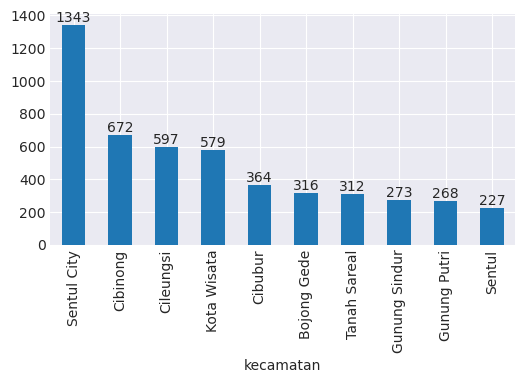

In [20]:
kecamatan_ax = df["kecamatan"].value_counts().head(10).plot.bar(figsize=(6, 3))
kecamatan_ax.bar_label(kecamatan_ax.containers[0])
plt.show()

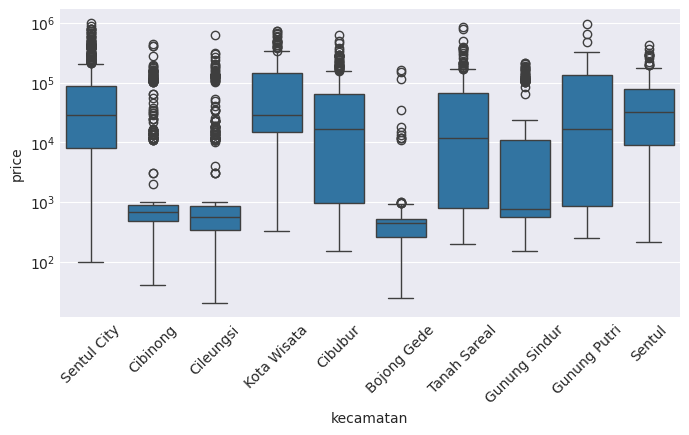

In [170]:
kec_top10 = df["kecamatan"].value_counts().head(10).index
df_kec = df[df["kecamatan"].isin(kec_top10)]

plt.figure(figsize=(8, 4))
sns.boxplot(data=df_kec, x="kecamatan", y="price", order=kec_top10)
plt.xticks(rotation=45)
plt.yscale("log")
plt.show()

## Analisis Agen

In [115]:
import re
import nltk

In [40]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/fahmi/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [145]:
def df_pretty(df, cmap="Reds"):
  return df.style.background_gradient(cmap=cmap).format(precision=2, thousands=".", decimal=",")

In [28]:
# normalize JSON to dataframe
df_agent_norm = pd.json_normalize(df["agent"])
df_agent_norm.columns = df_agent_norm.columns.str.replace(' ', '_').str.lower()

df_agent_norm["company.name"] = df_agent_norm["company.name"].str.upper()

# join with price and kecamatan
df_agent = df[["price", "kecamatan"]].copy().join(df_agent_norm)
df_agent.head(2)

,price,kecamatan,name,url,phone,company.name,company.url
0,295000.0,Sentul City,Heri Andrian,https://www.rumah123.com/agen-properti/nas-glo...,+628121859577,NAS GLOBAL PROPERTY,https://www.rumah123.com/agen-properti/nas-glo...
1,11000.0,Bogor Barat,PASHOUSES ID,https://www.rumah123.com/agen-properti/pashous...,NaN,PASHOUSES.ID,https://www.rumah123.com/agen-properti/pashous...


In [110]:
def agencies_bigrams_topk(l, n=20):
  # split words
  tokens = [x.split() for x in l]

  # frequency distribution for unigrams
  fdist_unigrams = nltk.FreqDist(itertools.chain(*tokens))

  # frequency distribution for bigrams
  tokens_bigrams = [list(nltk.bigrams(token)) for token in tokens]
  fdist_bigrams = nltk.FreqDist(itertools.chain(*tokens_bigrams))

  # return top n unigrams and bigrams
  return fdist_unigrams.most_common(n) + fdist_bigrams.most_common(n)

In [111]:
# top 20 agencies
raw_agencies = list(df_agent["company.name"].dropna().unique())
agencies_bigrams_topk(raw_agencies)

[('PROPERTY', 195),
 ('BRIGHTON', 56),
 ('ERA', 45),
 ('WHITE', 36),
 ('PRO', 34),
 ('RAY', 34),
 ('GADING', 33),
 ('REALTY', 33),
 ('CENTURY21', 32),
 ('PROPERTI', 29),
 ('JAKARTA', 17),
 ('LJ', 17),
 ('HOOKER', 17),
 ('XAVIER', 16),
 ('MARKS', 16),
 ('SERPONG', 15),
 ('INDAH', 15),
 ('CIBUBUR', 14),
 ('PIK', 13),
 ('PROPERTINDO', 13),
 (('RAY', 'WHITE'), 34),
 (('LJ', 'HOOKER'), 17),
 (('XAVIER', 'MARKS'), 16),
 (('GADING', 'SERPONG'), 12),
 (('MR', 'REALTY'), 11),
 (('KELAPA', 'GADING'), 9),
 (('REALTY', '-'), 9),
 (('PROPERTY', 'CIBUBUR'), 7),
 (('HARAPAN', 'INDAH'), 7),
 (('BRIGHTON', 'PRIORITY'), 7),
 (('ERA', 'FIESTA'), 7),
 (('ASIA', 'ONE'), 7),
 (('ALAM', 'SUTERA'), 7),
 (('CENTURY21', 'METRO'), 6),
 (('REAL', 'ESTATE'), 6),
 (('ONE', 'PROPERTY'), 6),
 (('PROPERTY', 'INDONESIA'), 5),
 (('GADING', 'PRO'), 5),
 (('PONDOK', 'INDAH'), 5),
 (('BRIGHTON', 'WINNER'), 5)]

In [146]:
def agencies_dedupe(name):
  # return empty if null
  if pd.isnull(name):
    return name
  
  # return common property names
  COMMON_COMPANY = ["BRIGHTON", "CENTURY21", "CENTURY 21", "RAY WHITE", "LJ HOOKER", "XAVIER MARKS", "MR REALTY", "ERA FIESTA", "ASIA ONE", "RE/MAX", "ERA PROJECT", "ERA VICTORIA", "MPRO"]
  for company in COMMON_COMPANY:
    if company in name:
      return company

  # remove common city names
  # COMMON_WORDS = ["PROPERTY", "PROPERTI", "BANDUNG", "JAKARTA", "GARDEN CITY", "GADING SERPONG", "KELAPA GADING", "CENGKARENG", "BINTARO", "BINTARO 3 BRANCH", "MALANG", "TANGERANG", "PALEMBANG"]
  # for word in COMMON_WORDS:
  #   if word in name:
  #     name = name.replace(word, "")

  # normalize common words
  if "PROPERTY" in name:
    name = name.replace("PROPERTY", "PROPERTI")
  if "NOT IDENTIFIED" in name:
    name = name.replace("NOT IDENTIFIED", "INDEPENDENT")
  if "INDEPDENDENT" in name:
    name = name.replace("INDEPDENDENT", "INDEPENDENT")

  # remove double spaces
  name = re.sub(' +', ' ', name).strip()

  # emtpty is independent
  if name == "":
    name = "INDEPENDENT"

  return name

# dedupe agencies
df_agent["company_name_dedupe"] = df_agent["company.name"].apply(agencies_dedupe)

# difference
print("Total agencies:", len(raw_agencies))
print("Total agencies after dedupe:", len(df_agent["company_name_dedupe"].dropna().unique()))
print("Total agencies removed:", len(raw_agencies) - len(df_agent["company_name_dedupe"].dropna().unique()))

Total agencies: 626
Total agencies after dedupe: 439
Total agencies removed: 187


In [143]:
df_agent_pivot = df_agent.pivot_table(index="company_name_dedupe", values="price", aggfunc=["count", "mean", "median", "std", "min", "max"])
df_pretty(df_agent_pivot.sort_values(by=("count", "price"), ascending=False).head(10))

,count,mean,median,std,min,max
,price,price,price,price,price,price
company_name_dedupe,,,,,,
PASHOUSES.ID,831,"69.689,33","12.000,00","85.403,62","430,00","391.000,00"
BRIGHTON,602,"48.180,17","11.000,00","100.789,42","110,00","825.000,00"
CENTURY21,576,"51.674,76","18.000,00","99.872,37","190,00","725.000,00"
MITRA PROPERTI SENTUL,325,"76.733,71","40.000,00","102.142,42","100,00","437.000,00"
RAY WHITE,323,"55.348,89","18.000,00","99.574,94","130,00","895.000,00"
ERA FAJAR,195,"57.801,36","14.000,00","118.047,45","191,00","899.000,00"
NAS GLOBAL PROPERTI,191,"90.969,42","45.000,00","116.563,89","465,00","725.000,00"
TRUSTY PROPERTI CIBUBUR,152,"63.818,82","18.000,00","101.862,05","350,00","799.000,00"


In [144]:
df_pretty(df_agent_pivot.sort_values(by=("mean", "price"), ascending=False).head(10))

,count,mean,median,std,min,max
,price,price,price,price,price,price
company_name_dedupe,,,,,,
TOMANGPRO,1,"785.000,00","785.000,00",nan,"785.000,00","785.000,00"
MAXI PROPERTI,3,"653.000,00","729.000,00","131.635,86","501.000,00","729.000,00"
NET PRO,1,"625.000,00","625.000,00",nan,"625.000,00","625.000,00"
BIZ PROPERTI,1,"475.000,00","475.000,00",nan,"475.000,00","475.000,00"
AGS PROPERTI,2,"399.900,00","399.900,00","564.412,63","800,00","799.000,00"
MEGAH PROPERTINDO,1,"349.000,00","349.000,00",nan,"349.000,00","349.000,00"
FIVE HOMES,2,"308.500,00","308.500,00","263.750,83","122.000,00","495.000,00"
JP PROPERTI CIBUBUR,2,"300.500,00","300.500,00","58.689,86","259.000,00","342.000,00"


## Analisis Tags

In [153]:
# copy price and tags
df_tags = df[["price", "kecamatan", "tags"]].copy()

# flatten tags and split by "/"
df_tags["tags_clean"] = df_tags["tags"].apply(lambda tags: list(set(itertools.chain.from_iterable([tag.lower().replace("24 jam", "").strip().split("/") for tag in tags]))))

# binarize tags
mlb_tags = MultiLabelBinarizer(sparse_output=True)
mlb_tags.fit_transform(df_tags["tags_clean"])

# create dataframe from sparse matrix
df_spm = pd.DataFrame.sparse.from_spmatrix(mlb_tags.transform(df_tags["tags_clean"]), columns=mlb_tags.classes_)
df_spm.columns = df_spm.columns.str.replace(' ', '_')

# join with price
df_tags = df_tags.join(df_spm).drop(columns=["tags_clean", "tags"])
df_tags.head(2)

,price,kecamatan,bisa_nego,cash_bertahap,cash_keras,dijual_cepat,komplek,kpr,masuk_gang,one_gate_system,pedesaan,perumahan,pinggir_jalan
0,295000.0,Sentul City,0,0,1,0,0,0,0,1,0,0,0
1,11000.0,Bogor Barat,1,0,1,0,0,1,0,0,0,0,0


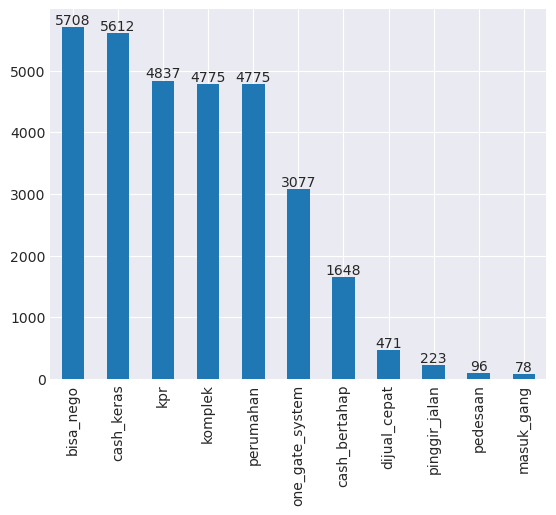

In [178]:
tags_ax = df_tags.iloc[:, 2:].sum().sort_values(ascending=False).plot.bar()
tags_ax.bar_label(tags_ax.containers[0])
plt.show()

<Axes: xlabel='kpr', ylabel='price'>

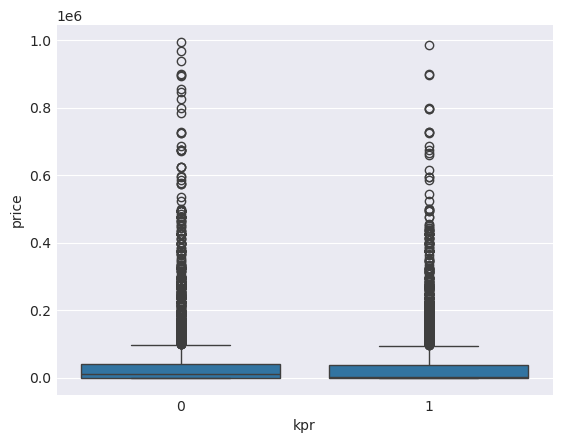

In [156]:
sns.boxplot(data=df_tags, x="kpr", y="price")

## Analisis Facilities

In [185]:
# get unique facilities
set(itertools.chain.from_iterable(df["facilities"].values))

['Lapangan Bola',
 'water heater',
 'Solar Hot Water',
 'Lapangan Bulu Tangkis',
 'Study',
 'Pam',
 '24 Hours Security',
 'Air Conditioning',
 'Air Pam',
 'Lapangan Voli',
 'Air Jet Pump',
 'bisa masuk parkir 12 mobil',
 'samping & belakang. Baru renovasi.Bahan istimewa :1. Atap full kayu bengkirai bukan baja ringan 2. Kusen kayu merbau3. Kaca sebagian tempered glass4. Cat jotun5. Lantai 2 parket kayu6. Keramik bawah import7. Dapur bersih & dapur kotor8. Lemari build in',
 'Teras',
 'Smoking Permitted',
 'Tempat Jemuran',
 'sertifikat SHM',
 'Swimming Pool',
 'Row Jalan Dalam Perumahan Luas',
 'Jogging Track',
 'Shed',
 'listrik',
 'Carport',
 'Lapangan Basket',
 'Aircon',
 'Workshop',
 'Tempat Gym',
 'Ac',
 'air PAM',
 'PAM',
 'Akses Parkir',
 'listrik token',
 'Wi-Fi',
 'Air Tanah',
 'Jalur Telepon',
 'Lapangan bermain. rumah hadap Selatan',
 'Keamanan 24 jam',
 'taman belakang',
 'Smart Door Lock',
 'Lapangan Tenis',
 'Gas',
 'Outdoor Entertaining',
 'Atap Baja Ringan',
 'Kolam Rena

In [203]:
def facilities_dedupe(facilities):  
  # inner function to clean facility info
  def clean_facility(name):
    # set uppercase
    name = name.upper()

    # remove outlier
    OUTLIERS = ["SAMPING & BELAKANG", "LISTRIK", "ATAP BAJA", "ROW JALAN", 'BUILT IN ROBES', "R.TAMU", "STUDY", "BATH", "R. MAKAN", "SERTIFIKAT", "HADAP"]
    for outlier in OUTLIERS:
      if outlier in name:
        return None    
    
    # replace rules to summarize facility
    RULESET = {
      "LAPANGAN BERMAIN": "PLAYGROUND",
      "PARKIR": "PARKIR",
      "JOGGING TRACK": "TRACK LARI",
      "JET PUMP": "AIR TANAH",
      "PAM": "AIR PAM",
      "CARPORT": "CARPORT",
      "GYM": "GYM",
      'SWIMMING POOL': "KOLAM RENANG",
      
      "AC": "AC",
      "AIR COND": "AC",
      "AIRCON": "AC",

      "SECURITY": "KEAMANAN",
      "KEAMANAN": "KEAMANAN",

      "COURTYARDS": "HALAMAN",
      "TERAS": "HALAMAN",
      
      "KITCHEN": "DAPUR",
      "KOMPOR": "DAPUR",
      "KULKAS": "DAPUR",

      "JEMURAN": "LAUNDRY",
      "LAUNDRY": "LAUNDRY",
      "CUCI": "LAUNDRY",

      "PEMANAS AIR": "WATER HEATER",
      "HOT WATER": "WATER HEATER",

      "TAMAN": "TAMAN",
      "GARDEN": "TAMAN",
      "ENTERTAINING": "TAMAN",
      
      "INTERNET": "INTERNET",
      "WIFI": "INTERNET",      
      "WI-FI": "INTERNET",
    }

    # return rule if found
    for rule in RULESET:
      if rule in name:
        return RULESET[rule]
    
    return name
  
  # return common property names
  return [x for x in set([clean_facility(tag) for tag in facilities]) if x is not None]

# dedupe facilities
all_facilities = [facilities_dedupe(facilities) for facilities in df["facilities"].values]
all_facilities = list(set(itertools.chain.from_iterable(all_facilities)))
list(sorted(all_facilities))

['AC',
 'AIR PAM',
 'AIR TANAH',
 'BALCONY',
 'CANOPY',
 'CARPORT',
 'CCTV',
 'DAPUR',
 'GAS',
 'GROUND FLOOR',
 'GYM',
 'HALAMAN',
 'INTERNET',
 'JALUR TELEPON',
 'KEAMANAN',
 'KOLAM IKAN',
 'KOLAM RENANG',
 'LAPANGAN BASKET',
 'LAPANGAN BOLA',
 'LAPANGAN BULU TANGKIS',
 'LAPANGAN TENIS',
 'LAPANGAN VOLI',
 'MASJID',
 'MESIN CUCI',
 'MUSHOLA',
 'ONE GATE SYSTEM',
 'PARKIR',
 'PET FRIENDLY',
 'PLAYGROUND',
 'SHED',
 'SMART DOOR LOCK',
 'SMOKING PERMITTED',
 'TAMAN',
 'TEMPAT JEMURAN',
 'TEMPAT LAUNDRY',
 'TRACK LARI',
 'WASTAFEL',
 'WATER HEATER',
 'WATER TANK',
 'WORKSHOP']

In [205]:
# copy price and facilities
df_facilities = df[["price", "facilities"]].copy()

# flatten facilities and dedupe it
df_facilities["facilities_clean"] = df_facilities["facilities"].apply(facilities_dedupe)

# create binarizer
mlb_facilities = MultiLabelBinarizer(sparse_output=True)
mlb_facilities.fit_transform(df_facilities["facilities_clean"])

# create dataframe from sparse matrix
df_spm = pd.DataFrame.sparse.from_spmatrix(mlb_facilities.transform(df_facilities["facilities_clean"]), columns=mlb_facilities.classes_)
df_spm.columns = df_spm.columns.str.replace(' ', '_').str.lower()

# join with price
df_facilities = df_facilities.join(df_spm).drop(columns=["facilities_clean", "facilities"])
df_facilities.head(2)

,price,ac,air_pam,air_tanah,balcony,canopy,carport,cctv,dapur,gas,...,smart_door_lock,smoking_permitted,taman,tempat_jemuran,tempat_laundry,track_lari,wastafel,water_heater,water_tank,workshop
0,295000.0,1,0,0,0,0,0,1,1,0,...,0,0,1,1,1,0,0,0,0,0
1,11000.0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


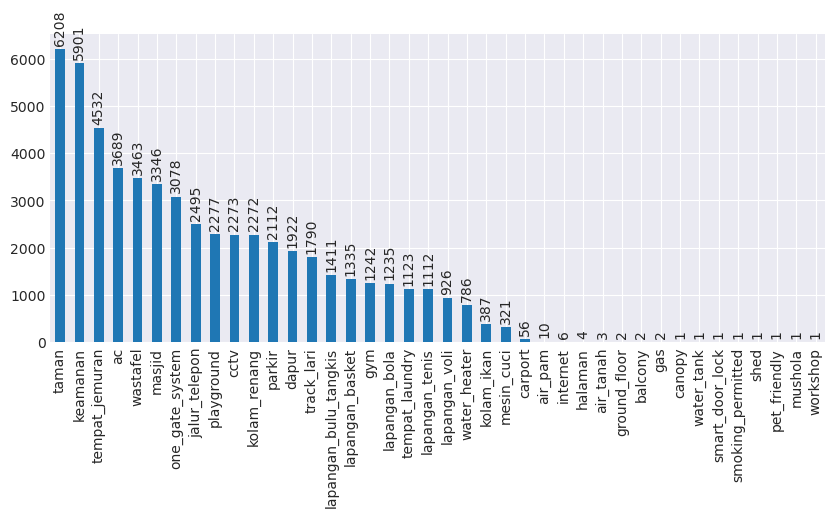

In [214]:
plt.figure(figsize=(10, 4))
fac_count_ax = df_facilities.iloc[:, 1:].sum().sort_values(ascending=False).plot.bar()
fac_count_ax.bar_label(fac_count_ax.containers[0], padding=3, rotation=90)
plt.show()

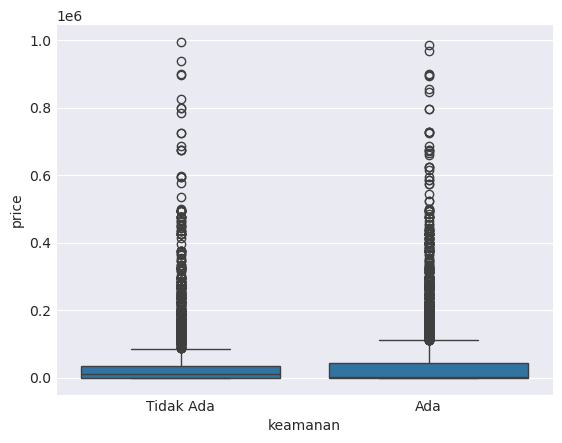

In [221]:
fac_price_ax = sns.boxplot(data=df_facilities, x="keamanan", y="price", formatter=lambda x: "Tidak Ada" if x == 0 else "Ada")
# plt.yscale("log")

## Analisis Specs

In [231]:
# normalize JSON to dataframe
df_spec_norm = pd.json_normalize(df["specs"])
df_spec_norm.columns = df_spec_norm.columns.str.replace(' ', '_').str.lower()

# transform to number
df_spec_norm["luas_tanah"] = df_spec_norm["luas_tanah"].str.replace("m²", "").astype(float)
df_spec_norm["luas_bangunan"] = df_spec_norm["luas_bangunan"].str.replace("m²", "").astype(float)
df_spec_norm["daya_listrik"] = df_spec_norm["daya_listrik"].str.lower().str.replace("watt", "").str.replace("lainnya", "0").astype(float)
df_spec_norm["lebar_jalan"] = df_spec_norm["lebar_jalan"].str.split(" ").str[0]

# transform to number
df_spec_norm = df_spec_norm.astype({
  'kamar_tidur': 'float64',
  'carport': 'float64',
  'kamar_mandi': 'float64',
  'kamar_pembantu': 'float64',
  'dapur': 'float64',
  'jumlah_lantai': 'float64',
  'garasi': 'float64',
  'lebar_jalan': 'float64',
  'tahun_di_renovasi': 'float64',
  'kamar_mandi_pembantu': 'float64',
  'tahun_dibangun': 'float64',
})

# join with price and vicinity
df_spec = df[["price", "kecamatan"]].copy().join(df_spec_norm)
df_spec.head(2)

,price,kecamatan,kamar_tidur,kamar_mandi,luas_tanah,luas_bangunan,carport,tipe_properti,sertifikat,daya_listrik,...,konsep_dan_gaya_rumah,pemandangan,terjangkau_internet,lebar_jalan,tahun_dibangun,sumber_air,hook,kondisi_properti,id_iklan,tahun_di_renovasi
0,295000.0,Sentul City,3.0,4.0,400.0,150.0,2.0,Rumah,SHM - Sertifikat Hak Milik,2200.0,...,Scandinavian,Pemukiman Warga,Ya,2.0,2002.0,PAM atau PDAM,Tidak,Bagus,hos13819879,NaN
1,11000.0,Bogor Barat,2.0,1.0,138.0,105.0,1.0,Rumah,HGB - Hak Guna Bangunan,2200.0,...,NaN,NaN,Tidak,NaN,NaN,PAM atau PDAM,Tidak,Bagus,hos13868613,NaN


<Axes: xlabel='kamar_tidur', ylabel='price'>

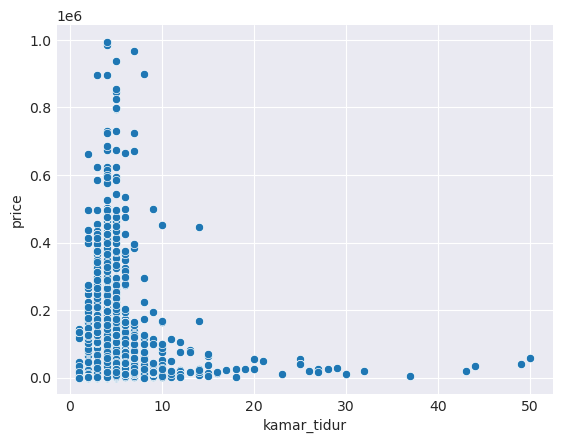

In [232]:
sns.scatterplot(df_spec, x="kamar_tidur", y="price")

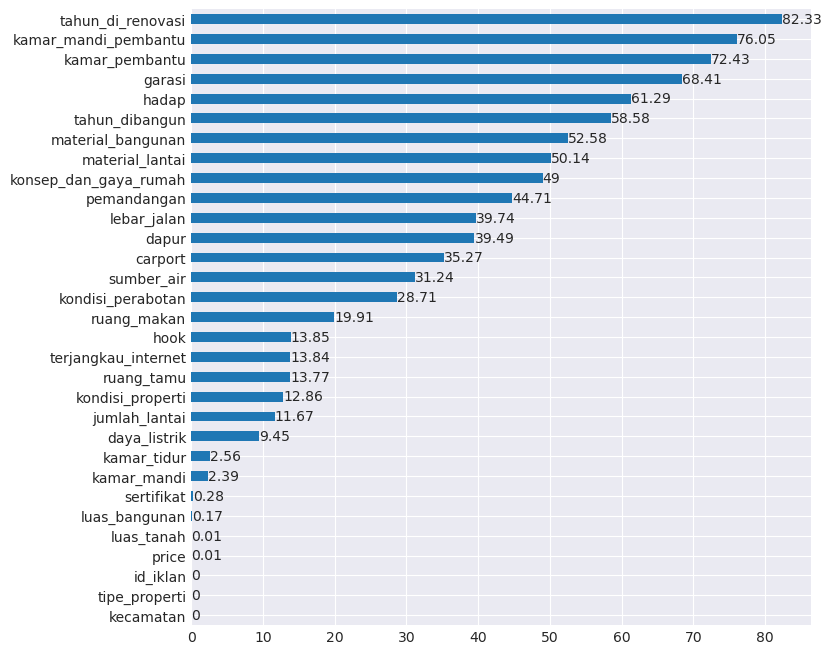

In [233]:
plt.figure(figsize=(8, 8))
ax = (df_spec.isna().sum() / df_spec.shape[0] * 100).sort_values(ascending=True).round(2).plot.barh()
ax.bar_label(ax.containers[0])
plt.show()

In [234]:
def plot_corr(df):
  df_corr = df.corr(numeric_only=True)
  mask = np.triu(np.ones_like(df_corr, dtype=bool))
  cmap = sns.diverging_palette(230, 20, as_cmap=True)

  fig, ax = plt.subplots(figsize=(10, 6))
  sns.heatmap(df_corr, ax=ax, annot=True, fmt=".2f", mask=mask, cmap=cmap, center=0)
  ax.grid()

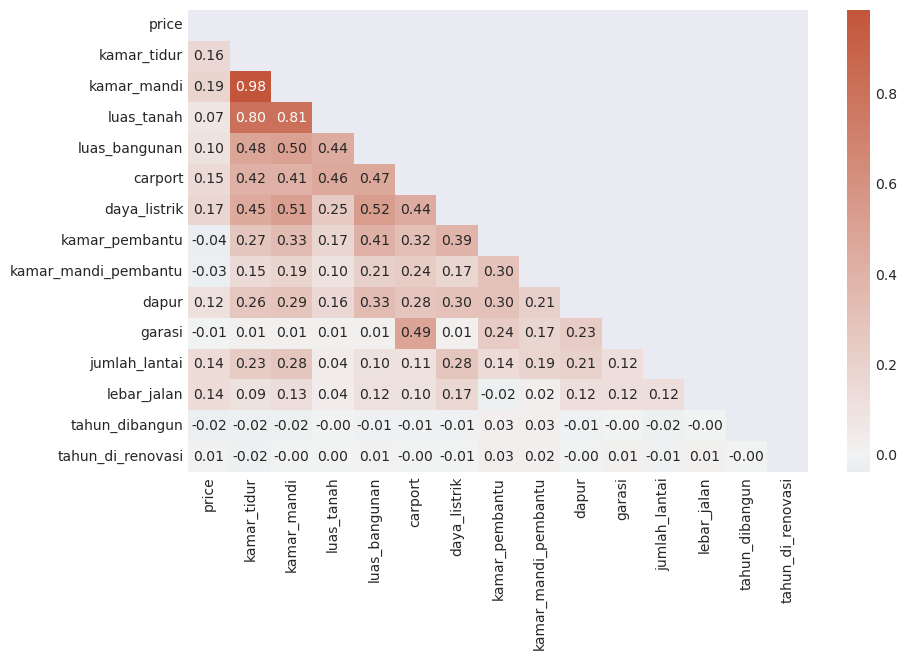

In [235]:
plot_corr(df_spec)

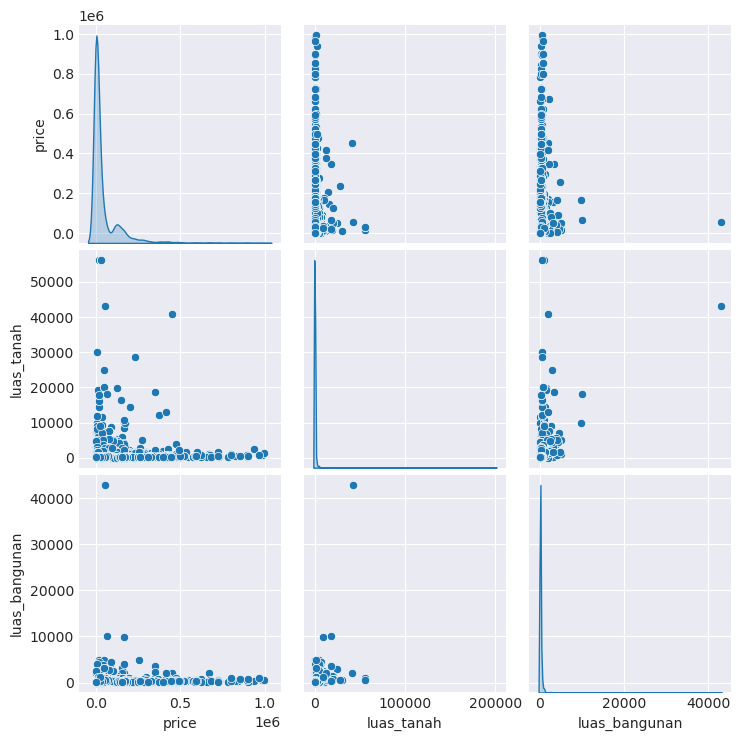

In [236]:
sns.pairplot(df_spec, diag_kind='kde', vars=["price", "luas_tanah", "luas_bangunan"])

In [237]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
  display(df_spec.iloc[0, :])

price                                      295000.0
kecamatan                               Sentul City
kamar_tidur                                     3.0
kamar_mandi                                     4.0
luas_tanah                                    400.0
luas_bangunan                                 150.0
carport                                         2.0
tipe_properti                                 Rumah
sertifikat               SHM - Sertifikat Hak Milik
daya_listrik                                 2200.0
kamar_pembantu                                  1.0
kamar_mandi_pembantu                            1.0
dapur                                           1.0
ruang_makan                                   Tidak
ruang_tamu                                    Tidak
kondisi_perabotan                       Unfurnished
material_bangunan                        Bata Merah
material_lantai                              Granit
garasi                                          2.0
jumlah_lanta

## Analisis Statistik Deskriptif

In [238]:
with pd.option_context('display.float_format', '{:.4f}'.format):
  display(sms.descriptivestats.describe(df_spec))

,price,kamar_tidur,kamar_mandi,luas_tanah,luas_bangunan,carport,daya_listrik,kamar_pembantu,kamar_mandi_pembantu,dapur,garasi,jumlah_lantai,lebar_jalan,tahun_dibangun,tahun_di_renovasi
nobs,9047.0000,9047.0000,9047.0000,9047.0000,9047.0000,9047.0000,9047.0000,9047.0000,9047.0000,9047.0000,9047.0000,9047.0000,9047.0000,9047.0000,9047.0000
missing,1.0000,232.0000,216.0000,1.0000,15.0000,3191.0000,855.0000,6553.0000,6880.0000,3573.0000,6189.0000,1056.0000,3595.0000,5300.0000,7448.0000
mean,45775.2184,3.2277,2.3988,396.4702,183.1969,1.5786,2691.0341,1.2109,1.0895,1.0796,2.4367,1.5216,2.0994,2020.6136,2004.1682
std_err,982.4065,0.0604,0.0603,28.0915,5.7867,0.0229,34.0195,0.0101,0.0101,0.0045,0.7699,0.0104,0.0082,7.1432,4.4800
upper_ci,47700.6998,3.3462,2.5170,451.5285,194.5385,1.6234,2757.7110,1.2307,1.1093,1.0884,3.9457,1.5420,2.1155,2034.6139,2012.9488
lower_ci,43849.7371,3.1092,2.2807,341.4118,171.8552,1.5337,2624.3572,1.1911,1.0698,1.0709,0.9277,1.5011,2.0833,2006.6132,1995.3877
std,93437.1360,5.6752,5.6640,2671.7966,549.9477,1.7513,3079.0911,0.5039,0.4691,0.3315,41.1600,0.9322,0.6073,437.2519,179.1424
iqr,38410.0000,2.0000,2.0000,153.0000,150.0000,1.0000,900.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,8.0000,3.0000
iqr_normal,28473.3756,1.4826,1.4826,113.4191,111.1952,0.7413,667.1710,0.0000,0.0000,0.0000,0.7413,0.7413,0.0000,5.9304,2.2239
mad,58239.1608,1.1748,1.2543,462.9213,152.0025,0.8176,1548.6020,0.3479,0.1662,0.1477,2.0688,0.5498,0.3626,21.8769,33.1812


## Analisis Harga

### Harga berdasarkan Lokasi

In [243]:
df_price = df_spec.pivot_table(index="kecamatan", values="price", aggfunc=["count", "mean", "median", "std", "min", "max"])
df_pretty(df_price.sort_values(("mean", "price"), ascending=False))

,count,mean,median,std,min,max
,price,price,price,price,price,price
kecamatan,,,,,,
Karang Tengah,2,"348.000,00","348.000,00","38.183,77","321.000,00","375.000,00"
Lawanggintung,1,"275.000,00","275.000,00",nan,"275.000,00","275.000,00"
Ahmadyani,6,"226.557,50","77.000,00","302.883,25","345,00","725.000,00"
Cibulan,1,"175.000,00","175.000,00",nan,"175.000,00","175.000,00"
Pabaton,8,"164.500,00","49.000,00","256.561,88","1.000,00","675.000,00"
Duta Pakuan,2,"159.000,00","159.000,00","178.190,91","33.000,00","285.000,00"
Sempur,14,"135.642,86","36.000,00","206.799,27","2.000,00","725.000,00"
Tegal Gundil,11,"134.513,64","25.000,00","262.755,46","650,00","897.000,00"


### Analisis Outlier

<Axes: xlabel='luas_tanah', ylabel='price'>

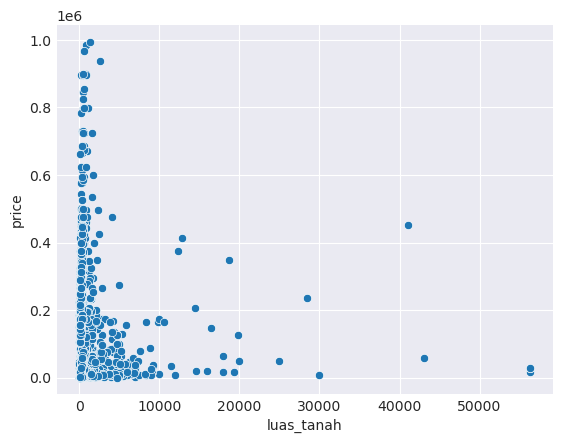

In [246]:
sns.scatterplot(data=df_spec, x="luas_tanah", y="price")

In [250]:
def plot_dist(df, col):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

  sns.kdeplot(data=df, x=col, ax=ax1)
  ax1.set_title("Distributions")

  sm.qqplot(df[col], line="s", ax=ax2)
  ax2.set_title("QQ Plot")

  fig.tight_layout()
  plt.show()

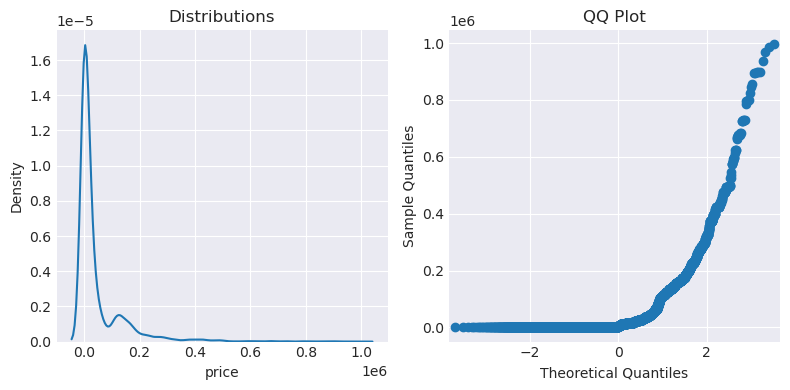

In [251]:
plot_dist(df_spec, "price")

### Outlier Removal dengan Z-score

In [300]:
def outlier_stats(dfo):
  total_data = dfo.shape[0]
  outliers_count = (dfo["is_outlier"] == True).sum()
  outliers_percent = outliers_count / total_data

  print("Total data:", total_data)
  print("Outliers count: {0:.2f} ({1:.2%})".format(outliers_count, outliers_percent))

In [304]:
df_outlier = df_spec.copy().dropna(subset=["price"])
df_outlier["price_zscore"] = stats.zscore(df_outlier["price"])
df_outlier["is_outlier"] = np.abs(df_outlier["price_zscore"]) > 3.0

print(outlier_stats(df_outlier))
df_outlier.head(2)

Total data: 9046
Outliers count: 193.00 (2.13%)
None


,price,kecamatan,kamar_tidur,kamar_mandi,luas_tanah,luas_bangunan,carport,tipe_properti,sertifikat,daya_listrik,...,lebar_jalan,tahun_dibangun,sumber_air,hook,kondisi_properti,id_iklan,tahun_di_renovasi,price_zscore,price_zscore_outlier,is_outlier
0,295000.0,Sentul City,3.0,4.0,400.0,150.0,2.0,Rumah,SHM - Sertifikat Hak Milik,2200.0,...,2.0,2002.0,PAM atau PDAM,Tidak,Bagus,hos13819879,NaN,2.667446,False,False
1,11000.0,Bogor Barat,2.0,1.0,138.0,105.0,1.0,Rumah,HGB - Hak Guna Bangunan,2200.0,...,NaN,NaN,PAM atau PDAM,Tidak,Bagus,hos13868613,NaN,-0.372198,False,False


<Axes: xlabel='luas_tanah', ylabel='price'>

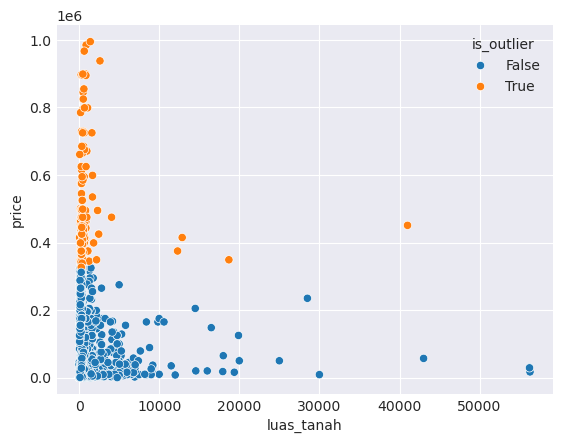

In [305]:
sns.scatterplot(data=df_outlier, x="luas_tanah", y="price", hue="is_outlier")

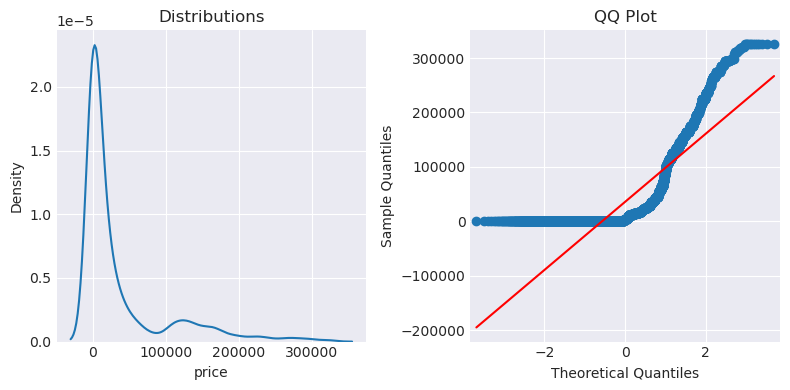

In [293]:
df_oulier_zscore_vis = df_outlier[df_outlier["is_outlier"] == False]
plot_dist(df_oulier_zscore_vis, "price")

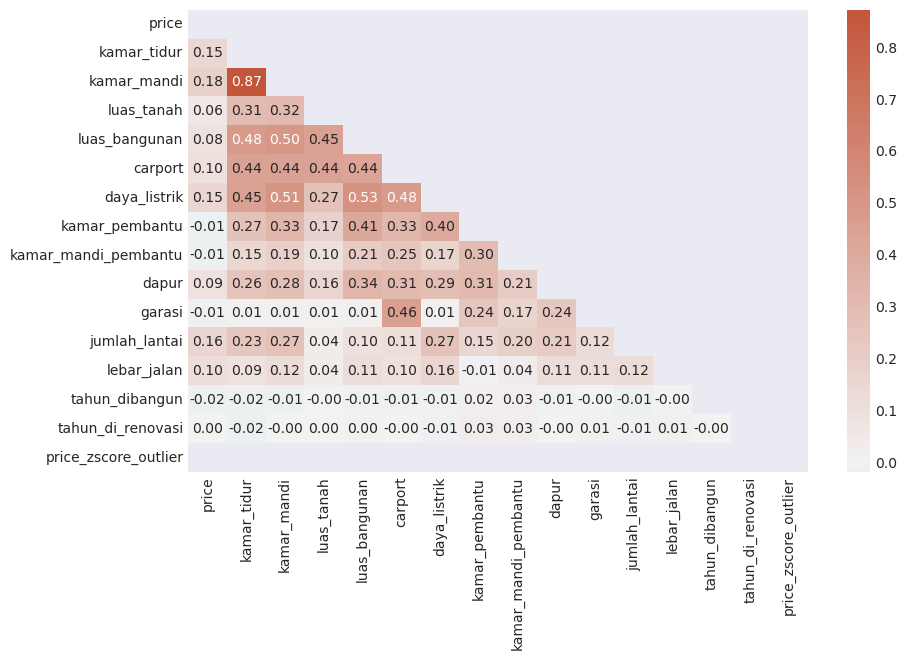

In [294]:
plot_corr(df_oulier_zscore_vis.drop(columns=["price_zscore", "is_outlier"]))

### Outlier Removal dengan IQR

In [306]:
df_outlier_iqr = df_spec.copy().dropna(subset=["price"])
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

threshold = 1.5
df_outlier_iqr["is_outlier"] = (df_outlier_iqr['price'] < Q1 - threshold * IQR) | (df_outlier_iqr['price'] > Q3 + threshold * IQR)

print(outlier_stats(df_outlier_iqr))
df_outlier_iqr.head(2)

Total data: 9046
Outliers count: 1593.00 (17.61%)
None


,price,kecamatan,kamar_tidur,kamar_mandi,luas_tanah,luas_bangunan,carport,tipe_properti,sertifikat,daya_listrik,...,lebar_jalan,tahun_dibangun,sumber_air,hook,kondisi_properti,id_iklan,tahun_di_renovasi,price_zscore,price_zscore_outlier,is_outlier
0,295000.0,Sentul City,3.0,4.0,400.0,150.0,2.0,Rumah,SHM - Sertifikat Hak Milik,2200.0,...,2.0,2002.0,PAM atau PDAM,Tidak,Bagus,hos13819879,NaN,NaN,False,True
1,11000.0,Bogor Barat,2.0,1.0,138.0,105.0,1.0,Rumah,HGB - Hak Guna Bangunan,2200.0,...,NaN,NaN,PAM atau PDAM,Tidak,Bagus,hos13868613,NaN,NaN,False,False


<Axes: xlabel='luas_tanah', ylabel='price'>

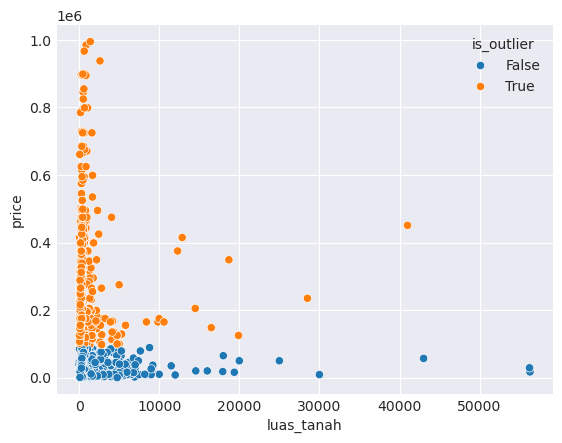

In [285]:
sns.scatterplot(data=df_outlier_iqr, x="luas_tanah", y="price", hue="is_outlier")

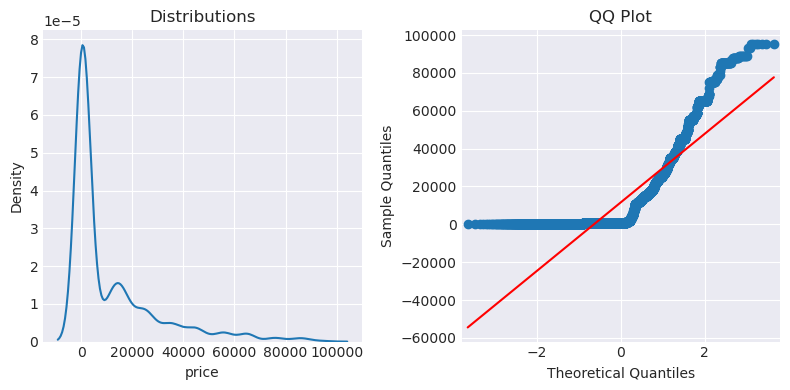

In [297]:
df_oulier_iqr_vis = df_outlier_iqr[df_outlier_iqr["is_outlier"] == False]
plot_dist(df_oulier_iqr_vis, "price")

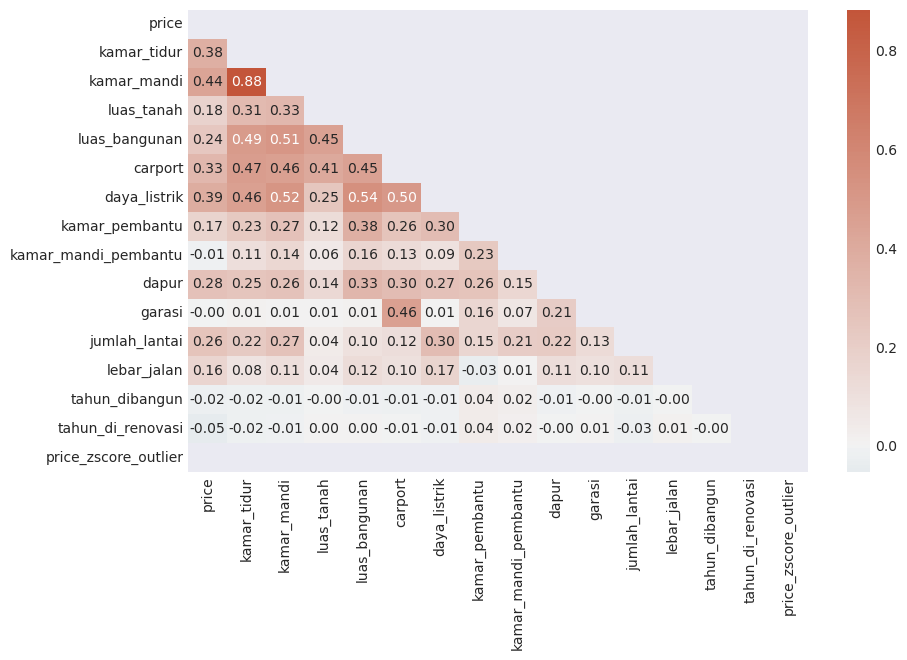

In [299]:
plot_corr(df_oulier_iqr_vis.drop(columns=["price_zscore", "is_outlier"]))